# Previously we couldn't see any difference between forward and backward when predicting the Bayesian particle trajectory with a BNN. But what if we decrease `hidden_size`?

In [1]:
from typing import Optional, List, Iterable, Tuple, Dict
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

import numpy.typing
NDArray = numpy.typing.NDArray[np.floating]

In [2]:
from brownian_datagen import (BrownianDatagen,
                              create_dataholder_for_windows_and_targets,
                              create_simple_flip_dataholder_for_windows_and_targets)
from bayesian import (posterior_predictive_forward_and_backward,
                      ExperimentResults, plot_predictions, quality_metrics)

In [3]:
def get_save_dir(hidden_size: int) -> str:
    save_dir_prefix = "20230724_preds/brownian_hidden_size_again/"
    return os.path.join(save_dir_prefix, f"hidden_size={hidden_size:02}/")

(<Figure size 500x1000 with 3 Axes>,
 array([<Axes: title={'center': 'Forward trajectories'}, xlabel='index', ylabel='coordinate of the particle, forward'>,
        <Axes: title={'center': 'Backward trajectories'}, xlabel='index', ylabel='coordinate of the particle, backward'>,
        <Axes: title={'center': 'Work distributions'}>], dtype=object))

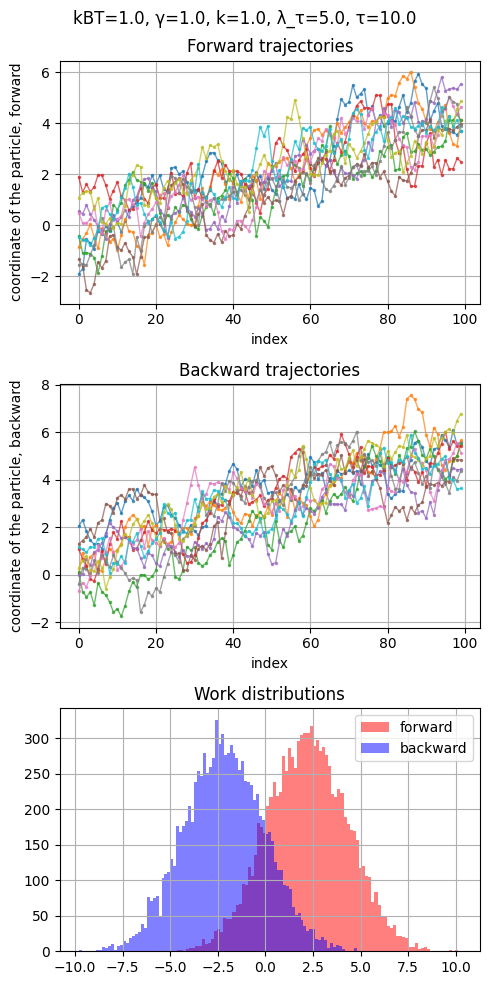

In [4]:
brownian = BrownianDatagen(kBT=1., γ=1., k=1., λ_τ=5., τ=10.)
dt = create_dataholder_for_windows_and_targets(brownian, numParticles=30, rng_seed=42)
brownian.visualize()

In [5]:
for hidden_size in (2, 4, 6, 8):
    save_dir = get_save_dir(hidden_size)
    if not os.path.isdir(save_dir):
        posterior_predictive_forward_and_backward(dt, save_dir=save_dir,
                                                  num_samples=100, hidden_size=hidden_size)
    else:
        print(f"Directory '{save_dir}' exists, assuming the previous results are reusable")

Directory '20230724_preds/brownian_hidden_size_again/hidden_size=02/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_hidden_size_again/hidden_size=04/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_hidden_size_again/hidden_size=06/' exists, assuming the previous results are reusable
Directory '20230724_preds/brownian_hidden_size_again/hidden_size=08/' exists, assuming the previous results are reusable


In [6]:
def glue_forward_backward_metrics(forward: Dict, backward: Dict) -> Dict:
    # return {key : (forward[key], backward[key]) for key in forward.keys()}
    return {key : f"{forward[key]:.2e}, {(forward[key] - backward[key]) / forward[key]:.2}" for key in forward.keys()}

In [7]:
print("Metrics on train, {'metric': 'forward, forward-backward reldiff'}")
for hidden_size in (2, 4, 6, 8):
    er = ExperimentResults(get_save_dir(hidden_size))
    print(f"hidden_size={hidden_size}:", glue_forward_backward_metrics(
        quality_metrics(er.pred_obs_f, er.targets_f),
        quality_metrics(er.pred_obs_b, er.targets_b)
    ))

Metrics on train, {'metric': 'forward, forward-backward reldiff'}
hidden_size=2: {'mae': '3.60e-01, 0.0065', 'rmse': '4.50e-01, 0.0074', 'crps': '2.55e-01, 0.0077', 'mean_std': '4.48e-01, 0.0052', 'mse_from_all': '4.02e-01, 0.013'}
hidden_size=4: {'mae': '3.58e-01, 0.00084', 'rmse': '4.50e-01, 0.0048', 'crps': '2.54e-01, 0.0042', 'mean_std': '4.47e-01, 0.0016', 'mse_from_all': '4.01e-01, 0.0065'}
hidden_size=6: {'mae': '3.59e-01, 0.0061', 'rmse': '4.50e-01, 0.0064', 'crps': '2.54e-01, 0.0057', 'mean_std': '4.49e-01, 0.0069', 'mse_from_all': '4.03e-01, 0.013'}
hidden_size=8: {'mae': '3.58e-01, 0.0015', 'rmse': '4.48e-01, 0.00082', 'crps': '2.54e-01, 0.0018', 'mean_std': '4.48e-01, 0.0046', 'mse_from_all': '4.01e-01, 0.0054'}


In [8]:
print("Metrics on test, {'metric': 'forward, forward-backward reldiff'}")
dt_test = create_dataholder_for_windows_and_targets(brownian, numParticles=30, rng_seed=24)
for hidden_size in (2, 4, 6, 8):
    er = ExperimentResults(get_save_dir(hidden_size))
    print(f"hidden_size={hidden_size}:", glue_forward_backward_metrics(
        quality_metrics(er.predictive_f(dt_test.windows_f)["obs"], er.targets_f),
        quality_metrics(er.predictive_b(dt_test.windows_b)["obs"], er.targets_b)
    ))

Metrics on test, {'metric': 'forward, forward-backward reldiff'}
hidden_size=2: {'mae': '1.20e+00, -0.0034', 'rmse': '1.51e+00, 0.00052', 'crps': '1.00e+00, -0.0049', 'mean_std': '4.47e-01, 0.0016', 'mse_from_all': '2.47e+00, 0.0012'}
hidden_size=4: {'mae': '1.20e+00, -0.0025', 'rmse': '1.51e+00, 0.0015', 'crps': '1.00e+00, -0.0029', 'mean_std': '4.49e-01, -0.016', 'mse_from_all': '2.47e+00, -0.012'}
hidden_size=6: {'mae': '1.20e+00, -0.0042', 'rmse': '1.51e+00, 0.0014', 'crps': '1.00e+00, -0.0049', 'mean_std': '4.50e-01, 0.006', 'mse_from_all': '2.47e+00, 0.0028'}
hidden_size=8: {'mae': '1.20e+00, -0.0053', 'rmse': '1.50e+00, -0.00029', 'crps': '1.00e+00, -0.0057', 'mean_std': '4.50e-01, -0.00074', 'mse_from_all': '2.47e+00, -0.0026'}


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='index', ylabel='target value'>)

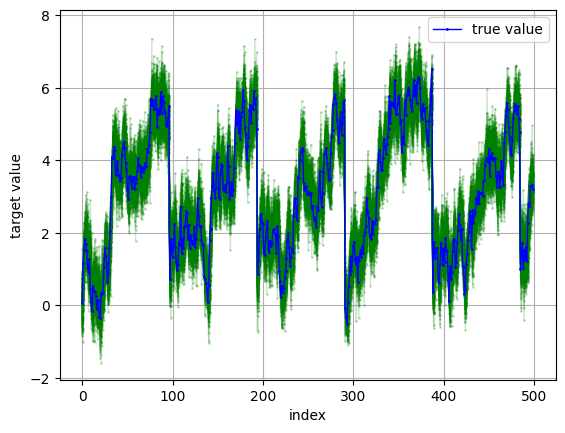

In [14]:
hidden_size = 2
er = ExperimentResults(get_save_dir(hidden_size))
plot_predictions(true=er.targets_b[:500], pred_all=er.pred_obs_b[:, :500])